# Assignment 9: PyTorch

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

- Kuang-Yu Li, st169971@stud.uni-stuttgart.de, 3440829,
- Ya-Jen Hsu, st169013@stud.uni-stuttgart.de, 3449448,
- Gabriella Ilena, st169935@stud.uni-stuttgart.de, 3440942

**Note on presenting: we would like to present either one of Task 1, Task 2, or Task 3.**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import skimage  # Package name: scikit-image, requires installation of package 'Pillow'
import skimage.io
import skimage.transform
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [ ]:
def load_airfoil_dataset():
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    data = np.genfromtxt('airfoil_self_noise.csv')
    X, y = data[:, :5], data[:, 5]
    y = y.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

    scaler_X = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train)
    X_train = scaler_X.transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.transform(y_train)
    y_test = scaler_y.transform(y_test)
    
    return X_train, X_test, y_train, y_test


def load_traffic_sign_dataset():
    import os
    
    def load_data(directory):
        directories = [d for d in os.listdir(directory)
                       if os.path.isdir(os.path.join(directory, d))]
        labels = []
        images = []
        for d in directories:
            label_directory = os.path.join(directory, d)
            file_names = [os.path.join(label_directory, f)
                          for f in os.listdir(label_directory)
                          if f.endswith(".ppm")]
            for f in file_names:
                images.append(skimage.io.imread(f))
                labels.append(int(d))
        images, labels = np.array(images), np.array(labels)
        images = np.array([skimage.transform.resize(img, (50, 50)) for img in images])
        return images, labels
            
    X_train, y_train = load_data('BelgiumTSC_Training/Training')
    X_test, y_test = load_data('BelgiumTSC_Testing/Testing')
    
    return X_train, X_test, y_train, y_test


In [ ]:
class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

    
class FlattenedImageDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = np.array([img.flatten() for img in X])
        self.y = y
        
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]


## Task 1: Linear Regression with SGD in PyTorch

In this first task, you will implement a linear regression model in PyTorch without using the existing [`torch.nn.Linear`](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) module. Instead use basic math operations such as addition and matrix multiplication for the computation of the forward pass. The computation of gradients and performing backpropagation will be automatically handled by PyTorch.

Initialize the weights and bias of the linear model using the standard Gaussian distribution similar to Assignment 8 - Task 3. The `bias` parameter selects whether a bias term should be included in the model.

*Hint:* To allow training of the network, the weights of the model have to be made trainable. A convenient way to do this is to instantiate the learnable parameters as [`torch.nn.Parameter`](https://pytorch.org/docs/master/generated/torch.nn.parameter.Parameter.html) objects and set them as fields of a [`torch.nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) subclass.

In [ ]:
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        
        # Your initialization code comes here.
        # Initialize weights and biases for a network of one hidden layer with 10 neurons
        self.w0 = nn.Parameter(torch.randn(in_features, 10))
        self.w1 = nn.Parameter(torch.randn(10, out_features))
        self.b0 = nn.Parameter(torch.randn(10))
        self.b1 = nn.Parameter(torch.randn(out_features))
    
    def forward(self, X):
        # The forward pass of the linear regression comes here.
        if self.bias:
          output0 = F.relu(torch.matmul(X, self.w0) + self.b0)
          output1 = torch.matmul(output0, self.w1) + self.b1
        else:
          output0 = F.relu(torch.matmul(X, self.w0))
          output1 = torch.matmul(output0, self.w1)
        return output1


We provide you with the necessary code to train and compare your model and the reference implementation of PyTorch. You will have to replicate similar training code for multi-class classification in Task 2.

In [ ]:
from sklearn.linear_model import LinearRegression

# Define hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 25
in_features = 5
out_features = 1

# Initialize models.
my_linear = MyLinear(in_features, out_features)
pt_linear = nn.Linear(in_features, out_features)

# Load dataset.
X_train, X_test, y_train, y_test = load_airfoil_dataset()
dataset_train = BasicDataset(X_train, y_train)


def train_model(model, dataset, learning_rate, batch_size, epochs): 
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Train linear model using SGD on mini-batches.
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
         # We want to report the training loss after each epoch
        epoch_loss = 0.0 

        for batch in data_loader:
            # After each iteration of the training step, reset the local gradients stored in the network to zero.
            model.zero_grad()
            model.zero_grad()

            # Compute the forward pass.
            # Numpy uses doubles by default but Torch expects floats, since the added accuracy of doubles 
            # is generally not useful for neural networks.
            # We fix this issue by changing the datatype of 'X' and 'y' with the .float method.
            yhat = model.forward(batch['X'].float())

            # Compute the batch error.
            batch_loss = F.mse_loss(yhat, batch['y'].float())
            epoch_loss += batch_loss.item()
            
            # Backpropagate the gradient and adjust the weights.
            batch_loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')

        
def evaluate_model(model, X_test, y_test):
    X_test = torch.from_numpy(X_test).float()    
    yhat = model.forward(X_test).detach().numpy()
    mse = np.mean(np.power(yhat - y_test, 2))
    print('Test MSE:', mse)
    
    
print('MyLinear')
train_model(my_linear, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(my_linear, X_test, y_test)
print()
print('torch.nn.Linear')
train_model(pt_linear, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(pt_linear, X_test, y_test)
print()
print('sklearn.linear_model.LinearRegression')
print('Test MSE:', np.mean(np.power(LinearRegression().fit(X_train, y_train).predict(X_test) - y_test, 2)))

MyLinear
Epoch 1/25 - Loss: 91.13768291473389
Epoch 2/25 - Loss: 44.97123908996582
Epoch 3/25 - Loss: 31.981707215309143
Epoch 4/25 - Loss: 24.90233027935028
Epoch 5/25 - Loss: 20.518372774124146
Epoch 6/25 - Loss: 17.719110250473022
Epoch 7/25 - Loss: 15.907654702663422
Epoch 8/25 - Loss: 14.759256482124329
Epoch 9/25 - Loss: 13.6659876704216
Epoch 10/25 - Loss: 13.003238499164581
Epoch 11/25 - Loss: 12.374032318592072
Epoch 12/25 - Loss: 11.696290850639343
Epoch 13/25 - Loss: 11.362845659255981
Epoch 14/25 - Loss: 11.146796733140945
Epoch 15/25 - Loss: 10.77384352684021
Epoch 16/25 - Loss: 10.450253963470459
Epoch 17/25 - Loss: 10.258813321590424
Epoch 18/25 - Loss: 10.056430608034134
Epoch 19/25 - Loss: 9.872610479593277
Epoch 20/25 - Loss: 9.533533364534378
Epoch 21/25 - Loss: 9.702335983514786
Epoch 22/25 - Loss: 9.576628595590591
Epoch 23/25 - Loss: 9.249733060598373
Epoch 24/25 - Loss: 9.291343629360199
Epoch 25/25 - Loss: 9.16940250992775
Test MSE: 0.5993040937351587

torch.nn.

## Task 2: Image Classification with FNN

In this task, you will implement an FNN for multi-class classification of traffic signs.

Download the [training](https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip) and [test](https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip) data. Unpack the zip-files in the same directory as the Jupyter notebook.

The shape of each image is `(width=50, height=50, channels=3)` after resizing. The channels represent the color of each pixel.
FNN cannot directly operate on images. We therefore have to flatten each image to a vector.
We achieve this with the [`numpy.flatten`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) method. The class `FlattenedImageDataset` may be used for training of your FNN.

Implement a feedforward neural network with multiple layers using either [`nn.Sequential`](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html) class or by subclassing [`nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) as shown in Task 1.  Use a combination [`nn.Linear`](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) and activation functions (e.g. [`nn.ReLU`](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)) to implement the fully connected layers of an FNN. Experiment with different activation functions (ReLU, tanh, ...), different depths, and widths. Use the Adam optimizer ([`optim.Adam`](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)) for optimization.

You should evaluate your model by at least computing the relevant metrics (e.g. F1-score) and looking at a few misclassified samples.

*Note:* You may modify the code from Task 1. However, you need to use an appropriate loss function and output layer for your FNN to train your network for multi-class classification. Use your knowledge from the lecture to identify the correct methods in the [PyTorch documentation](https://pytorch.org/docs/stable/index.html).

In [ ]:
from skimage.transform import resize
# Load training and testing data.
X_train, X_test, y_train, y_test = load_traffic_sign_dataset()
print('Training samples:', X_train.shape[0])
print('Testing samples:', X_test.shape[0])
print('Image shape:', X_train[0].shape)
print('Test image shape:', X_test[0].shape)
print('#Classes:', len(np.unique(y_train)))

# Pre-processing: resize all sample images to be of shape 128 * 128 *3
X_train_resized = list()
X_test_resized = list()

for x_tr in X_train:
  x = resize(x_tr, (128, 128))
  X_train_resized.append(x)
X_train_resized = np.asarray(X_train_resized, dtype=np.float32)

for x_ts in X_test:
  x = resize(x_ts, (128, 128))
  X_test_resized.append(x)
X_test_resized = np.asarray(X_test_resized, dtype=np.float32)

print('New image shape:', X_train_resized[0].shape, X_test_resized[0].shape)
print('Data type:', type(X_train_resized))

Training samples: 4575
Testing samples: 2520
Image shape: (50, 50, 3)
Test image shape: (50, 50, 3)
#Classes: 62
New image shape: (128, 128, 3) (128, 128, 3)
Data type: <class 'numpy.ndarray'>


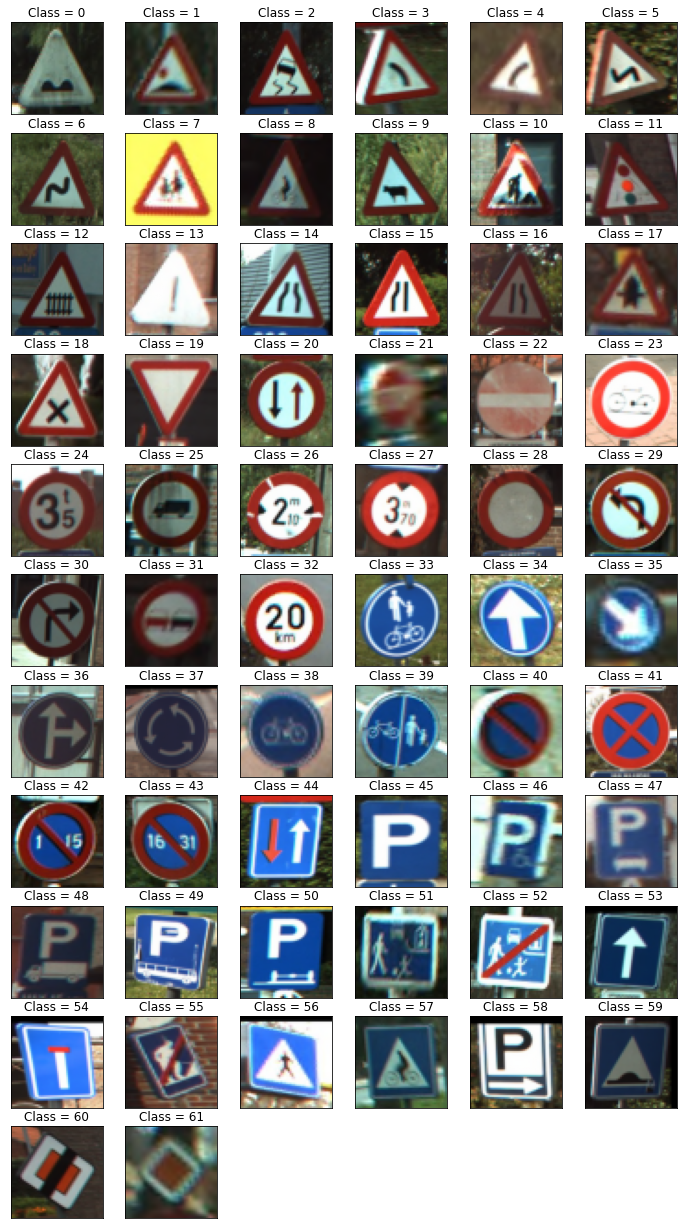

In [ ]:
# Show sample for each class.
class_labels = set(np.unique(y_train))
n_classes = len(class_labels)

n_cols = 6
n_rows = n_classes // n_cols + 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
for label in sorted(class_labels):
    row = label // n_cols
    col = label % n_cols
    img_idx = np.argmax(y_train == label)
    ax[row, col].imshow(X_train[img_idx])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_title(f'Class = {label}')
    
leftover_subplots = n_cols - (max(class_labels) % n_cols) - 1
for i in range(leftover_subplots):
    fig.delaxes(ax[-1, -(i+1)])

In [ ]:
# Implement your model and training here.

# Define hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 15
in_features = 128 * 128 * 3
out_features = 62

# Flatten image
flattened_train = FlattenedImageDataset(X_train_resized, y_train)

# Define a network with two dense hidden layers with 256 and 128 neurons each
model = nn.Sequential(
          nn.Linear(128*128*3, 256),
          nn.LeakyReLU(),
          nn.Linear(256, 128),
          nn.LeakyReLU(),
          nn.Linear(128, 62),
          nn.LogSoftmax(dim=1)
          )

def train_model(model, dataset, learning_rate, batch_size, epochs): 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_func = nn.NLLLoss()

    # Train linear model using SGD on mini-batches.
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        epoch_loss = 0.0 

        for batch in data_loader:
            # After each iteration of the training step, reset the local gradients stored in the network to zero.
            model.zero_grad()
            model.zero_grad()

            # Prediction
            yhat = model(batch['X'].float())

            # Compute the batch error.
            batch_loss = loss_func(yhat, batch['y'].long())
            epoch_loss += batch_loss.item()
            
            # Backpropagate the gradient and adjust the weights.
            batch_loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')

# Training
print("Start training:")
train_model(model, dataset=flattened_train, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)

Start training:
Epoch 1/15 - Loss: 224.9858466386795
Epoch 2/15 - Loss: 102.8583260178566
Epoch 3/15 - Loss: 64.270193785429
Epoch 4/15 - Loss: 46.89392736554146
Epoch 5/15 - Loss: 33.86452090740204
Epoch 6/15 - Loss: 26.671793967485428
Epoch 7/15 - Loss: 24.630249708890915
Epoch 8/15 - Loss: 19.833628199994564
Epoch 9/15 - Loss: 17.394603483378887
Epoch 10/15 - Loss: 13.256563477218151
Epoch 11/15 - Loss: 9.649563360959291
Epoch 12/15 - Loss: 12.819396547973156
Epoch 13/15 - Loss: 17.313436463475227
Epoch 14/15 - Loss: 11.997785858809948
Epoch 15/15 - Loss: 6.870950801298022


In [ ]:
# Implement your evaluation here.
import sklearn.metrics as skmetric

def evaluate_model(model, X_test):
    X_test = torch.from_numpy(X_test).float()    
    yhat = model(X_test).detach().numpy()
    yhat = np.argmax(yhat, axis=1) # Finding the predicted class
    return yhat

# Flatten and reshape the test data
X_test_resized_ori = X_test_resized
X_test_resized = X_test_resized.flatten().reshape(X_test_resized.shape[0], 128*128*3)

# Get predictions
y_pred = evaluate_model(model, X_test_resized)

# Test scores
print("Test report:")
print("Accuracy:", skmetric.accuracy_score(y_test, y_pred))
print("F1 score:", skmetric.f1_score(y_test, y_pred, average='weighted'))

Test report:
Accuracy: 0.8603174603174604
F1 score: 0.8594704671546738


## Task 3: Image Classification with CNN
For all students other than B.Sc. Data Science.
In this task, you will implement a convolutional neural network (CNN) for classification of traffic signs. Your model should use nn.Conv2d layers to compute convolutions, any kind of pooling (e.g. nn.MaxPool2d), and a dense output network. For inspiration look at the architecture of AlexNet (presented in the lecture). For simplicity, you may use the nn.Sequential class.
You should evaluate your model by at least computing the relevant metrics (e.g. F1-score) and looking at a few misclassified samples.
Note: For the most part, you can reuse your code from Task 2. However, you have to use images in their original format (128, 128, 3) instead of the flattened shape.

In [ ]:
# Define hyperparameters
batch_size = 64

class AlexNet(nn.Module):
    def __init__(self, num_classes=62):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # input 3 x 128 x 128
            nn.Conv2d(3, 64, kernel_size=12, stride=4),    # 64 x 30 x 30
            nn.ReLU(inplace=True),                         # size not change
            nn.MaxPool2d(kernel_size=4, stride=2),         # 64 x 14 x 14
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # 192 x 14 x 14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=2),         # 192 x 6 x 6
            nn.Conv2d(192, 384, kernel_size=3, padding=1), # 384 x 6 x 6
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # 256 x 6 x 6
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=2),         # 256 x 2 x 2
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 2 * 2, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.contiguous()
        x = x.view(-1, 256 * 2 * 2)  # reduce the dimensions for linear layer input
        x = self.classifier(x)
        return x

# create optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Using GPU train')
else:
    print('Using CPU train')
alexnet = AlexNet().to(device)
optimizer = optim.Adam(params=alexnet.parameters(), lr=0.0001)

def train(dataset, epochs):

    data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    for epoch in range(epochs):
        for i_batch, batch in enumerate(data_loader):

            # calculate the loss
            output = alexnet(batch['X'].float().to(device))
            loss = F.cross_entropy(output, batch['y'].long().to(device))

            # update the parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs} - Loss: {loss}')

            

Using GPU train


In [ ]:
X_train_resized_swapped = X_train_resized.swapaxes(1, 3).swapaxes(2, 3)
print(X_train_resized_swapped.shape)
alex_dataset_train = BasicDataset(X_train_resized_swapped, y_train)
train(alex_dataset_train, 25)
print(y_train[0])

(4575, 3, 128, 128)
Epoch 1/25 - Loss: 3.378856658935547
Epoch 2/25 - Loss: 2.7836296558380127
Epoch 3/25 - Loss: 2.3352131843566895
Epoch 4/25 - Loss: 1.5726367235183716
Epoch 5/25 - Loss: 1.6676758527755737
Epoch 6/25 - Loss: 1.678678035736084
Epoch 7/25 - Loss: 0.8604997396469116
Epoch 8/25 - Loss: 1.013279676437378
Epoch 9/25 - Loss: 0.5474116206169128
Epoch 10/25 - Loss: 0.8796671628952026
Epoch 11/25 - Loss: 0.49225905537605286
Epoch 12/25 - Loss: 0.5694087147712708
Epoch 13/25 - Loss: 0.5123001933097839
Epoch 14/25 - Loss: 0.5013430118560791
Epoch 15/25 - Loss: 0.4307091534137726
Epoch 16/25 - Loss: 0.2088271677494049
Epoch 17/25 - Loss: 0.351237952709198
Epoch 18/25 - Loss: 0.22595274448394775
Epoch 19/25 - Loss: 0.5884476900100708
Epoch 20/25 - Loss: 0.20692986249923706
Epoch 21/25 - Loss: 0.11086516082286835
Epoch 22/25 - Loss: 0.1763172596693039
Epoch 23/25 - Loss: 0.22638455033302307
Epoch 24/25 - Loss: 0.5532816648483276
Epoch 25/25 - Loss: 0.37973982095718384
59


In [ ]:
# Evaluating the model
from sklearn.metrics import classification_report, confusion_matrix

print(X_test_resized_ori.swapaxes(1, 3).swapaxes(2, 3).shape)
X_test_resized_swapped = X_test_resized_ori.swapaxes(1, 3).swapaxes(2, 3)
X_test_resized_swapped = torch.from_numpy(X_test_resized_swapped).float().to(device)
print(X_test_resized_swapped.shape)
output = alexnet(X_test_resized_swapped)

y_pred = np.argmax(output.cpu().detach().numpy(), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Confusion matrix')
print(conf_matrix)
print('Classification report')
print(report)
print("Accuracy:", skmetric.accuracy_score(y_test, y_pred))
print("F1 score:", skmetric.f1_score(y_test, y_pred, average='weighted'))

(2520, 3, 128, 128)
torch.Size([2520, 3, 128, 128])
Confusion matrix
[[  1   5   0 ...   0   0   0]
 [  1  25   0 ...   0   0   0]
 [  0   0   1 ...   0   0   0]
 ...
 [  0   0   0 ...  16   0   0]
 [  0   0   0 ...   0   8   3]
 [  0   0   0 ...   0   0 105]]
Classification report
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.83      0.93      0.88        27
           2       1.00      0.14      0.25         7
           3       0.67      0.33      0.44         6
           4       0.29      0.17      0.21        12
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         6
           7       0.72      0.81      0.76        90
           8       0.55      0.50      0.52        12
           9       0.00      0.00      0.00         0
          10       0.70      0.50      0.58        28
          12       0.30      1.00      0.46         3
          13  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
